In [ ]:
%matplotlib inline



# Parsing events from raw data

This tutorial describes how to read experimental events from raw recordings,
and how to convert between the two different representations of events within
MNE-Python (Events arrays and Annotations objects).

In the `introductory tutorial <overview-tut-events-section>` we saw an
example of reading experimental events from a :term:`"STIM" channel <stim
channel>`; here we'll discuss :term:`events` and :term:`annotations` more
broadly, give more detailed information about reading from STIM channels, and
give an example of reading events that are in a marker file or included in
the data file as an embedded array. The tutorials `tut-event-arrays` and
`tut-annotate-raw` discuss how to plot, combine, load, save, and
export :term:`events` and `~mne.Annotations` (respectively), and the
latter tutorial also covers interactive annotation of `~mne.io.Raw`
objects.

We'll begin by loading the Python modules we need, and loading the same
`example data <sample-dataset>` we used in the `introductory tutorial
<tut-overview>`, but to save memory we'll crop the `~mne.io.Raw` object
to just 60 seconds before loading it into RAM:


In [1]:
import numpy as np
import mne

sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = (sample_data_folder / 'MEG' / 'sample' /
                        'sample_audvis_raw.fif')
raw = mne.io.read_raw_fif(sample_data_raw_file)
raw.crop(tmax=60).load_data()

Using default location ~/mne_data for sample...
Creating ~/mne_data


100%|#####################################| 1.65G/1.65G [00:00<00:00, 1.65TB/s]
Untarring contents of 'C:\Users\metod\mne_data\MNE-sample-data-processed.tar.gz' to 'C:\Users\metod\mne_data'


Attempting to create new mne-python configuration file:
C:\Users\metod\.mne\mne-python.json
Opening raw data file C:\Users\metod\mne_data\MNE-sample-data\MEG\sample\sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading 0 ... 36037  =      0.000 ...    60.000 secs...


<Raw | sample_audvis_raw.fif, 376 x 36038 (60.0 s), ~106.7 MB, data loaded>

## The Events and Annotations data structures

Generally speaking, both the Events and `~mne.Annotations` data
structures serve the same purpose: they provide a mapping between times
during an EEG/MEG recording and a description of what happened at those
times. In other words, they associate a *when* with a *what*. The main
differences are:

1. **Units**: the Events data structure represents the *when* in terms of
   samples, whereas the `~mne.Annotations` data structure represents
   the *when* in seconds.
2. **Limits on the description**: the Events data structure represents the
   *what* as an integer "Event ID" code, whereas the `~mne.Annotations` data
   structure represents the *what* as a string.
3. **How duration is encoded**: Events in an Event array do not have a
   duration (though it is possible to represent duration with pairs of
   onset/offset events within an Events array), whereas each element of an
   `~mne.Annotations` object necessarily includes a duration (though
   the duration can be zero if an instantaneous event is desired).
4. **Internal representation**: Events are stored as an ordinary
   :class:`NumPy array <numpy.ndarray>`, whereas `~mne.Annotations` is
   a :class:`list`-like class defined in MNE-Python.



## What is a STIM channel?

A :term:`stim channel` (short for "stimulus channel") is a channel that does
not receive signals from an EEG, MEG, or other sensor. Instead, STIM channels
record voltages (usually short, rectangular DC pulses of fixed magnitudes
sent from the experiment-controlling computer) that are time-locked to
experimental events, such as the onset of a stimulus or a button-press
response by the subject (those pulses are sometimes called `TTL`_ pulses,
event pulses, trigger signals, or just "triggers"). In other cases, these
pulses may not be strictly time-locked to an experimental event, but instead
may occur in between trials to indicate the type of stimulus (or experimental
condition) that is about to occur on the upcoming trial.

The DC pulses may be all on one STIM channel (in which case different
experimental events or trial types are encoded as different voltage
magnitudes), or they may be spread across several channels, in which case the
channel(s) on which the pulse(s) occur can be used to encode different events
or conditions. Even on systems with multiple STIM channels, there is often
one channel that records a weighted sum of the other STIM channels, in such a
way that voltage levels on that channel can be unambiguously decoded as
particular event types. On older Neuromag systems (such as that used to
record the sample data) this "summation channel" was typically ``STI 014``;
on newer systems it is more commonly ``STI101``. You can see the STIM
channels in the raw data file here:



Removing projector <Projection | PCA-v1, active : False, n_channels : 102>
Removing projector <Projection | PCA-v2, active : False, n_channels : 102>
Removing projector <Projection | PCA-v3, active : False, n_channels : 102>


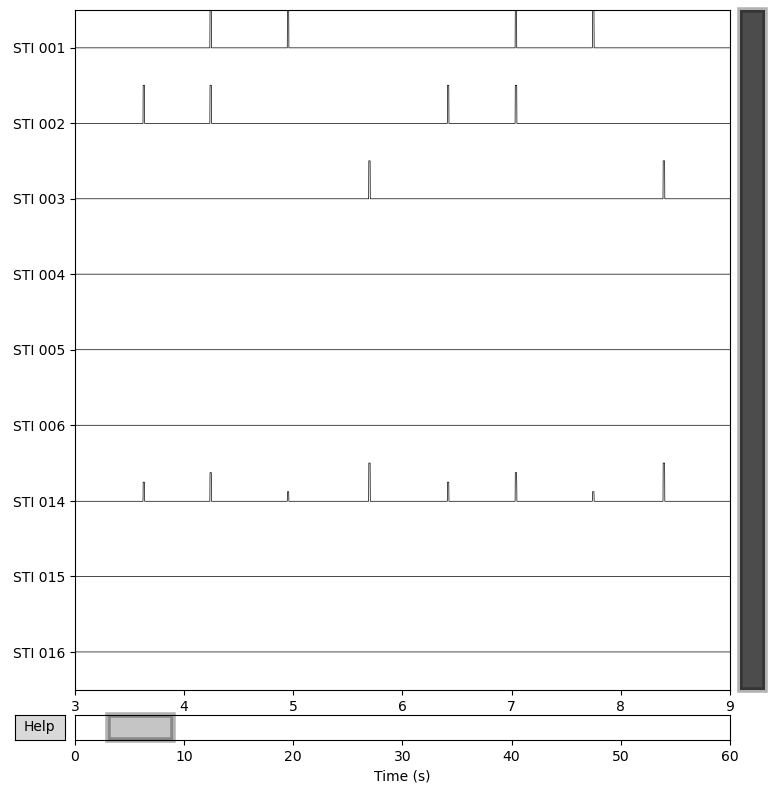

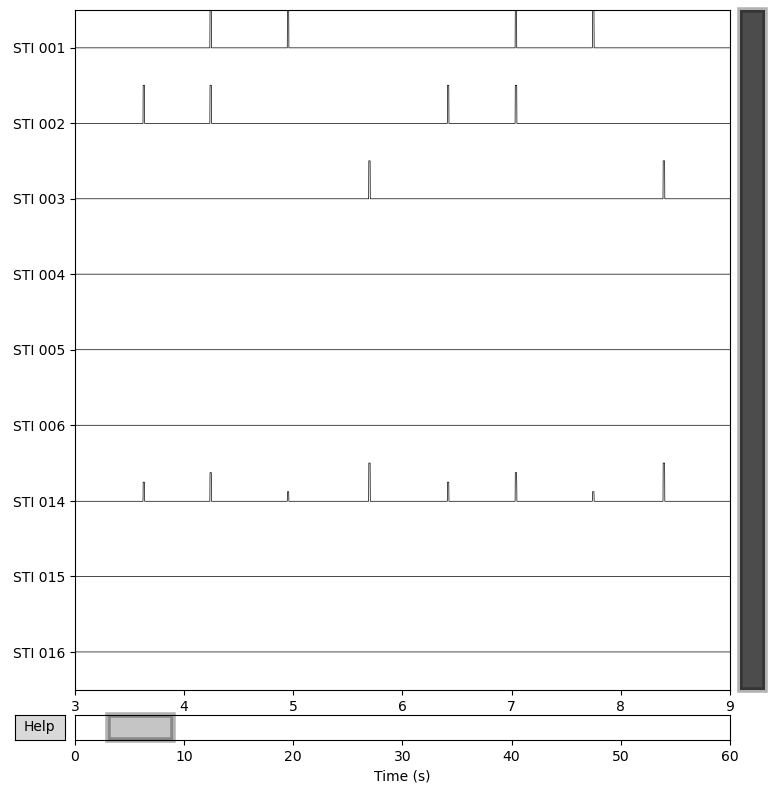

In [4]:
raw.copy().pick_types(meg=False, stim=True).plot(start=3, duration=6)

You can see that ``STI 014`` (the summation channel) contains pulses of
different magnitudes whereas pulses on other channels have consistent
magnitudes. You can also see that every time there is a pulse on one of the
other STIM channels, there is a corresponding pulse on ``STI 014``.

.. TODO: somewhere in prev. section, link out to a table of which systems
   have STIM channels vs. which have marker files or embedded event arrays
   (once such a table has been created).


## Converting a STIM channel signal to an Events array

If your data has events recorded on a STIM channel, you can convert them into
an events array using `~mne.find_events`. The sample number of the onset
(or offset) of each pulse is recorded as the event time, the pulse magnitudes
are converted into integers, and these pairs of sample numbers plus integer
codes are stored in :class:`NumPy arrays <numpy.ndarray>` (usually called
"the events array" or just "the events"). In its simplest form, the function
requires only the `~mne.io.Raw` object, and the name of the channel(s)
from which to read events:



In [5]:
events = mne.find_events(raw, stim_channel='STI 014')
print(events[:5])  # show the first 5

86 events found
Event IDs: [ 1  2  3  4  5 32]
[[27977     0     2]
 [28345     0     3]
 [28771     0     1]
 [29219     0     4]
 [29652     0     2]]


.. admonition:: The middle column of the Events array
    :class: sidebar note

    MNE-Python events are actually *three* values: in between the sample
    number and the integer event code is a value indicating what the event
    code was on the immediately preceding sample. In practice, that value is
    almost always ``0``, but it can be used to detect the *endpoint* of an
    event whose duration is longer than one sample. See the documentation of
    `~mne.find_events` for more details.

If you don't provide the name of a STIM channel, `~mne.find_events`
will first look for MNE-Python `config variables <tut-configure-mne>`
for variables ``MNE_STIM_CHANNEL``, ``MNE_STIM_CHANNEL_1``, etc. If those are
not found, channels ``STI 014`` and ``STI101`` are tried, followed by the
first channel with type "STIM" present in ``raw.ch_names``. If you regularly
work with data from several different MEG systems with different STIM channel
names, setting the ``MNE_STIM_CHANNEL`` config variable may not be very
useful, but for researchers whose data is all from a single system it can be
a time-saver to configure that variable once and then forget about it.

`~mne.find_events` has several options, including options for aligning
events to the onset or offset of the STIM channel pulses, setting the minimum
pulse duration, and handling of consecutive pulses (with no return to zero
between them). For example, you can effectively encode event duration by
passing ``output='step'`` to `~mne.find_events`; see the documentation
of `~mne.find_events` for details. More information on working with
events arrays (including how to plot, combine, load, and save event arrays)
can be found in the tutorial `tut-event-arrays`.


## Reading embedded events as Annotations

Some EEG/MEG systems generate files where events are stored in a separate
data array rather than as pulses on one or more STIM channels. For example,
the EEGLAB format stores events as a collection of arrays in the :file:`.set`
file. When reading those files, MNE-Python will automatically convert the
stored events into an `~mne.Annotations` object and store it as the
:attr:`~mne.io.Raw.annotations` attribute of the `~mne.io.Raw` object:



In [ ]:
testing_data_folder = mne.datasets.testing.data_path()
eeglab_raw_file = testing_data_folder / 'EEGLAB' / 'test_raw.set'
eeglab_raw = mne.io.read_raw_eeglab(eeglab_raw_file)
print(eeglab_raw.annotations)

The core data within an `~mne.Annotations` object is accessible
through three of its attributes: ``onset``, ``duration``, and
``description``. Here we can see that there were 154 events stored in the
EEGLAB file, they all had a duration of zero seconds, there were two
different types of events, and the first event occurred about 1 second after
the recording began:



In [ ]:
print(len(eeglab_raw.annotations))
print(set(eeglab_raw.annotations.duration))
print(set(eeglab_raw.annotations.description))
print(eeglab_raw.annotations.onset[0])

More information on working with `~mne.Annotations` objects, including
how to add annotations to `~mne.io.Raw` objects interactively, and how
to plot, concatenate, load, save, and export `~mne.Annotations`
objects can be found in the tutorial `tut-annotate-raw`.


## Converting between Events arrays and Annotations objects

Once your experimental events are read into MNE-Python (as either an Events
array or an `~mne.Annotations` object), you can easily convert between
the two formats as needed. You might do this because, e.g., an Events array
is needed for epoching continuous data, or because you want to take advantage
of the "annotation-aware" capability of some functions, which automatically
omit spans of data if they overlap with certain annotations.

To convert an `~mne.Annotations` object to an Events array, use the
function `mne.events_from_annotations` on the `~mne.io.Raw` file
containing the annotations. This function will assign an integer Event ID to
each unique element of ``raw.annotations.description``, and will return the
mapping of descriptions to integer Event IDs along with the derived Event
array. By default, one event will be created at the onset of each annotation;
this can be modified via the ``chunk_duration`` parameter of
`~mne.events_from_annotations` to create equally spaced events within
each annotation span (see `chunk-duration`, below, or see
`fixed-length-events` for direct creation of an Events array of
equally-spaced events).



In [ ]:
events_from_annot, event_dict = mne.events_from_annotations(eeglab_raw)
print(event_dict)
print(events_from_annot[:5])

If you want to control which integers are mapped to each unique description
value, you can pass a :class:`dict` specifying the mapping as the
``event_id`` parameter of `~mne.events_from_annotations`; this
:class:`dict` will be returned unmodified as the ``event_dict``.

Note that this ``event_dict`` can be used when creating `~mne.Epochs` from
`~mne.io.Raw` objects, as demonstrated in the tutorial
`tut-epochs-class`.



In [ ]:
custom_mapping = {'rt': 77, 'square': 42}
(events_from_annot,
 event_dict) = mne.events_from_annotations(eeglab_raw, event_id=custom_mapping)
print(event_dict)
print(events_from_annot[:5])

To make the opposite conversion (from an Events array to an
`~mne.Annotations` object), you can create a mapping from integer
Event ID to string descriptions, use `~mne.annotations_from_events`
to construct the `~mne.Annotations` object, and call the
`~mne.io.Raw.set_annotations` method to add the annotations to the
`~mne.io.Raw` object.

Because the `sample data <sample-dataset>` was recorded on a Neuromag
system (where sample numbering starts when the acquisition system is
initiated, not when the *recording* is initiated), we also need to pass in
the ``orig_time`` parameter so that the onsets are properly aligned relative
to the start of recording:



In [ ]:
mapping = {1: 'auditory/left', 2: 'auditory/right', 3: 'visual/left',
           4: 'visual/right', 5: 'smiley', 32: 'buttonpress'}
annot_from_events = mne.annotations_from_events(
    events=events, event_desc=mapping, sfreq=raw.info['sfreq'],
    orig_time=raw.info['meas_date'])
raw.set_annotations(annot_from_events)

Now, the annotations will appear automatically when plotting the raw data,
and will be color-coded by their label value:



In [ ]:
raw.plot(start=5, duration=5)


## Making multiple events per annotation

As mentioned above, you can generate equally-spaced events from an
`~mne.Annotations` object using the ``chunk_duration`` parameter of
`~mne.events_from_annotations`. For example, suppose we have an
annotation in our `~mne.io.Raw` object indicating when the subject was
in REM sleep, and we want to perform a resting-state analysis on those spans
of data. We can create an Events array with a series of equally-spaced events
within each "REM" span, and then use those events to generate (potentially
overlapping) epochs that we can analyze further.



In [ ]:
# create the REM annotations
rem_annot = mne.Annotations(onset=[5, 41],
                            duration=[16, 11],
                            description=['REM'] * 2)
raw.set_annotations(rem_annot)
(rem_events,
 rem_event_dict) = mne.events_from_annotations(raw, chunk_duration=1.5)

Now we can check that our events indeed fall in the ranges 5-21 seconds and
41-52 seconds, and are ~1.5 seconds apart (modulo some jitter due to the
sampling frequency). Here are the event times rounded to the nearest
millisecond:



In [ ]:
print(np.round((rem_events[:, 0] - raw.first_samp) / raw.info['sfreq'], 3))

Other examples of resting-state analysis can be found in the online
documentation for `~mne.make_fixed_length_events`.

.. LINKS


